#### set-up

In [ ]:
## tsfresh 라이브러리 설치
# %pip install tsfresh

## 라이브러리 버전 충돌을 피하기 위해 런타임을 재시작합니다.
# import os
# os.kill(os.getpid(), 9)

In [ ]:
# 먼저 데이터가 저장된 폴더를 연결합시다.
# !mkdir -p aiffel/time_series_basic
# !cp data/AirPassengers.csv aiffel/time_series_basic/

In [2]:
# 라이브러리를 불러옵니다.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Air Passenger 
- TimeSeries data preprocessing

In [4]:
# 데이터 불러오기
# air passengers 데이터를 불러옵니다.
ap = pd.read_csv('/Users/kwonkyoungmi/workspaces/workspace_Python/Git_AtAiffel/TimeSeries/AirPassengers.csv')

In [8]:
# 'Month' column을 삭제합니다.
ap.columns
ap.drop(columns='Month', inplace=True)

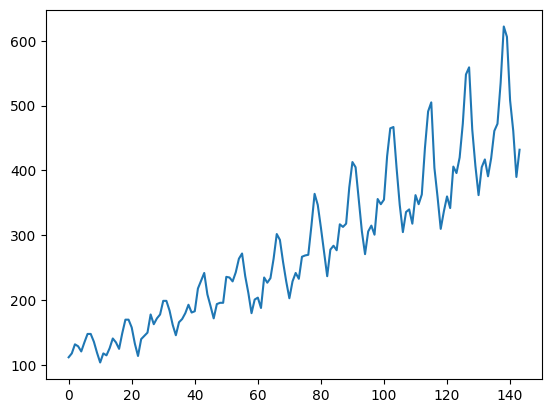

In [ ]:
# 선 그래프 => 평균에 대한 선 그래프
# 'Month' column을 인덱스로 설정합니다.
plt.figure()
plt.plot(ap)
plt.show()

#> 추세가 있고, 계절성이 있는 시계열 데이터임을 확인

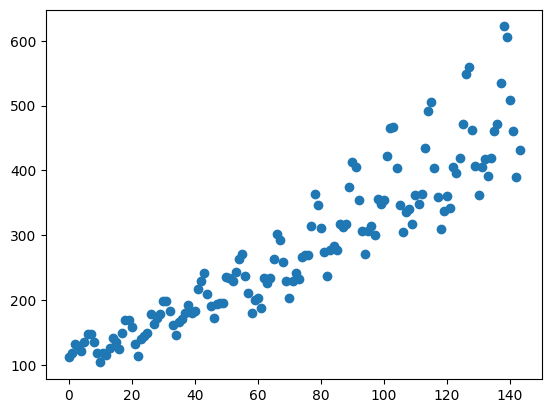

In [ ]:
# 산점도 그래프 => 분산확인
plt.scatter(ap.index, ap['#Passengers'])
plt.show()
#> 약정상성가정을 위해 분산을 일정하게 만들 필요 있음 확인

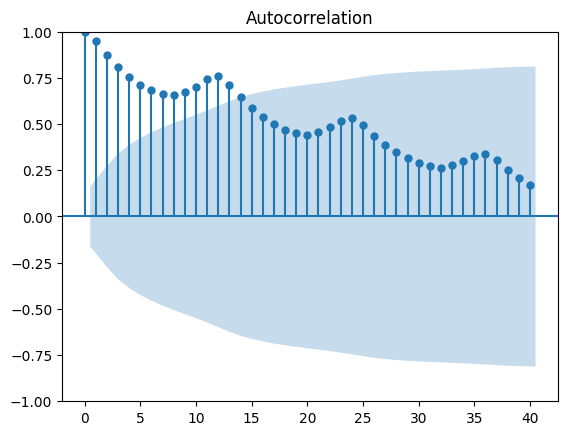

In [ ]:
# 자기상관성
# statsmodels은 통계 모델 추정, 통계 결과, 통계 데이터 탐색을 지원하는 python 모듈
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# ACF(자기상관함수) / ACF는 MA(q)모델을 설정하는 데 유용함
plot_acf(ap['#Passengers'], lags=40)
plt.show()

#> 파란색 음영은 신뢰구간을 나타냄 ; 자기상관계수가 통계적으로 유의미한지 판단 = 막대가 파란색 범위 안에 있으면 통계적으로 유의미 하지 않음을 뜻함
#> 정상 시계열의 ACF는 자기 상관이 빠르게 0으로 수렴해야 함 = 초기의 몇 개의 lag을 제외하고는 대부분의 lag에서 막대가 파란색 음영안에 들어와야 함
#> 1, 12, 24 시점에서 유의미한 자기상관관계가 존재함 = 12개월 주기로 계절성이 존재함을 확인 => 차분을 통해 정상성을 확보 필요

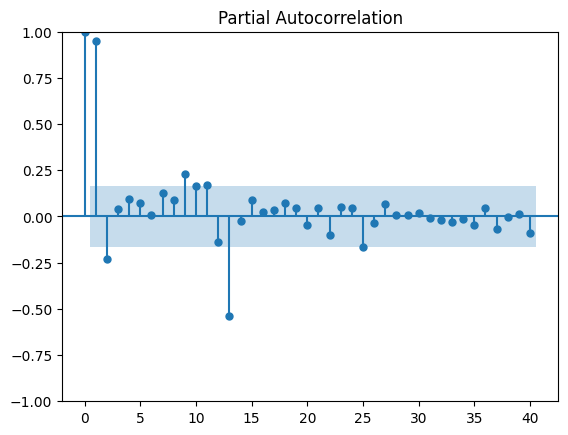

In [ ]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# PACF(부분자기상관함수) 시각화
# PACF는 자기상관계수를 제거한 후 남은 부분을 나타내는 함수 => 현재값과 과거값사이의 상관관계를 나타냄(중간 lag 상관계수 고려 안함), 부분별 자기 상관계수
# PACF는 AR(p)모델을 설정하는 데 사용됨
plot_pacf(ap['#Passengers'], lags=40)
plt.show()

#> 파란색 음영은 신뢰구간을 나타냄 ; 자기상관계수가 통계적으로 유의미한지 판단 = 막대가 파란색 범위 안에 있으면 통계적으로 유의미 하지 않음을 뜻함

#> ACF와 PACF를 통해 ARIMA 모델을 설정할 수 있는 정보를 제공함
#> 1,2,3,12 시점에서 유의미한 부분자기상관관계가 존재함 = 12개월 주기로 계절성이 존재함을 확인
#> ARIMA 모델을 설정하기 위해 p, d, q를 결정할 수 있는 정보를 제공함 => Arima 모델에서 AR(1) 성분과 계절성 AR(12) 성분을 고려해야 함

In [ ]:
# ADF 검정 : 단위근 검정
from statsmodels.tsa.stattools import adfuller
# ADF 검정 수행
adf_outputs = adfuller(ap['#Passengers'], autolag='AIC')
# ADF 검정 결과 출력
print('ADF Statistic:', adf_outputs[0])
print('p-value:', adf_outputs[1])

#> ADF 검정 결과 : 정상성을 띄지 않음
#  ADF Statistic: 0.8153688792060472 ; 음수이고 절대값이 클수록 정상성에 가까움
# p-value: 0.991880243437641 ; 0.05보다 크므로 귀무가설을 기각할 수 없음 = 귀무가설 채택
#   귀무가설 : 시계열 데이터는 정상성을 띄지 않는다. (시계열이 단위근을 가진다)
#   대립가설 : 시계열 데이터는 정상성을 띈다. (시계열이 단위근을 가지지 않는다)

ADF Statistic: 0.8153688792060472
p-value: 0.991880243437641


In [ ]:
# KPSS 검정
from statsmodels.tsa.stattools import kpss

# KPSS 검정 수행
kpss_outputs = kpss(ap['#Passengers'], regression='c', nlags='auto') 
                                        # regression='c' 정수상수항 'c'를 포함한 회귀모형 
                                        # nlags='auto' : 자동으로 lag 수를 결정

# 검정 결과 출력
print('KPSS Statistic:', kpss_outputs[0])
print('p-value:', kpss_outputs[1])


#> KPSS 검정 결과 : 정상성을 띄지 않음
#  KPSS Statistic: 1.651 ; 유의수준에 따라 판단 ; 1% 유의수준 (0.739)/ 5% 유의수준 (0.463)/ 10% 유의수준 (0.347)
# KPSS Statistic: 1.6513122354165206
# p-value: 0.01 : 0.05보다 작으므로 귀무가설을 기각 = 정상성을 띄지 않는다
#  귀무가설 : 시계열 데이터는 정상성을 띈다
#  대립가설 : 시계열 데이터는 정상성을 띄지 않는다


# usedlag : 사용된 시차의 수
# nobs : ADF 회귀 및 임계값 계산에 사용된 관측치의 수
# critical values(임계값) : 1%, 5% 및 10% 수준에서 테스트 통계에 대한 임계값
# icbest : 0, 1, …, maxlag 값 중 lag 길이를 자동으로 결정할 때 autolag를 사용하며 이때 
#          autolag를 none으로 지정할 수 있는데 none으로 지정하지 않는 경우 최대화된 정보 기준

KPSS Statistic: 1.6513122354165206
p-value: 0.01


/var/folders/t3/2n0cthkn35z3g9p87_tw_5wm0000gn/T/ipykernel_22435/3244518167.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_outputs = kpss(ap['#Passengers'], regression='c', nlags='auto')


### 정상성 확보

In [ ]:
## log transformation 후 차분을 통해 정상성 확보

# np.log를 통해서 log transformation
log_transformed = np.log(ap)

## 추세와 계절성이 모두 존재할 경우 차분적용 순서 - 추세제거 후 그 결과 데이터로 계절성 제거 (추세 -> 계절성)
# 차분을 통해 추세 제거
diffed = log_transformed.diff().dropna()

# 계절 차분 통해 주체 제거
seasonal_diffed = diffed.diff(12).dropna()

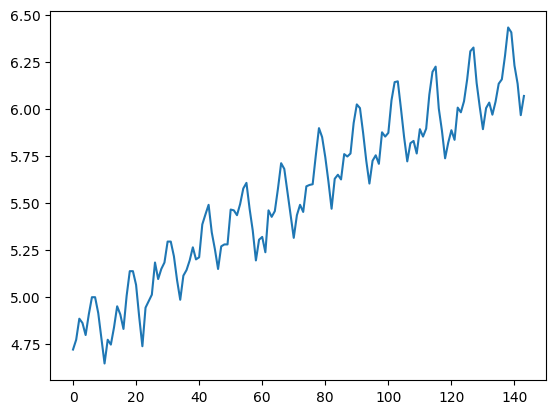

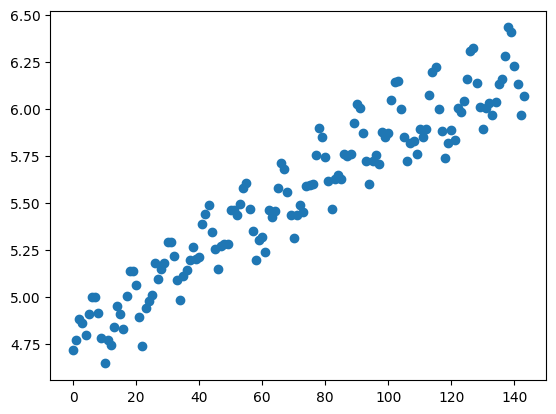

In [20]:
# 그래프확인 - 분산
plt.figure()   
plt.plot(log_transformed)
plt.show()

plt.figure()
plt.scatter(log_transformed.index, log_transformed['#Passengers'])
plt.show()

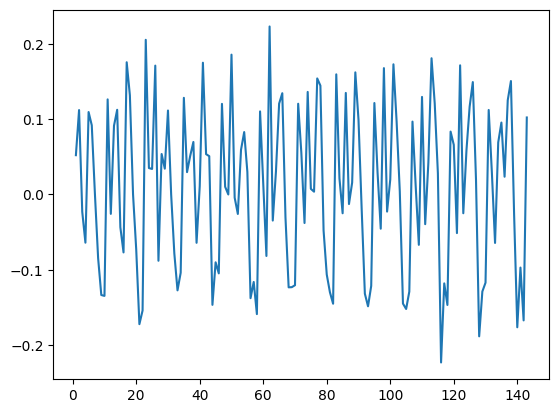

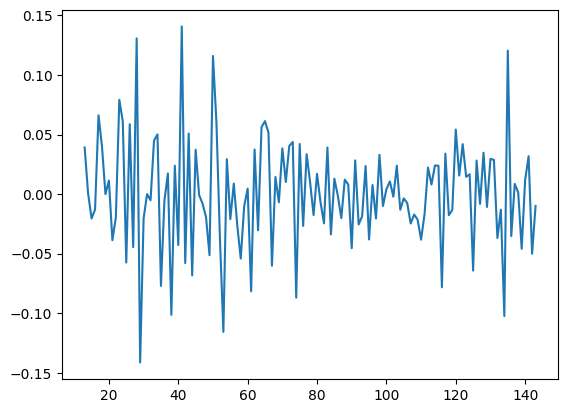

In [ ]:
# 그래프 확인 - 추세제거

# 추세 제거 by 차분
plt.figure()
plt.plot(diffed)
plt.show()
#> 일정한 평균(여기에서는 0)근처에서 오르내리는 모습을 보임을 확인 ; 상승/하락 추세가 보이지 않음
#> 평균으로의 회귀 (데이터가 평균에 멀리 벗어라더라도 다시 그 평균으로 돌아오려는 경향)
#> 그래프의 변동 폭이 시간에 따라 크게 달라지지 않음 확인 ; 분산이 일정하게 유지됨을 확인 


# 계절성 제거 by 차분
plt.figure()
plt.plot(seasonal_diffed)
plt.show()

#> 그래프의 변동 폭이 일정하지 않음 확인 ; (로그변환을 했다면) 백색 잡음(White Noise)에 가까운 작은 변동폭을 의미할 가능성이 높음
#  백색 잡음(White Noise) : 평균이 0이고 분산이 일정한 랜덤한 잡음 / 자기상관이 없는 시계열 => ACF/PACF 그래프를 통해 확인 할 것!(파란음영안 빠르게 수렴하는지 확인 필요함)

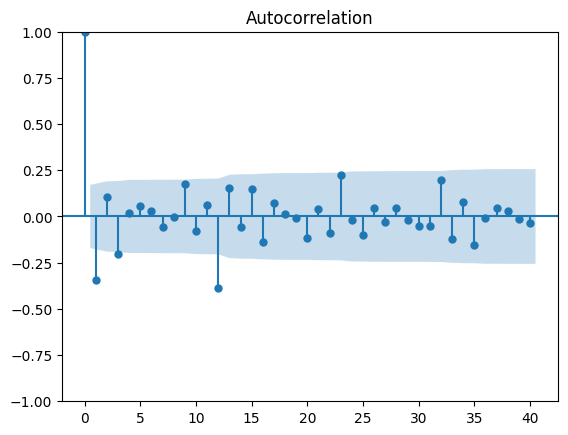

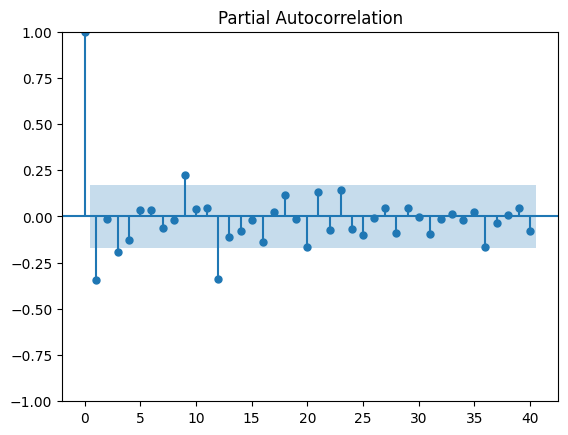

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# ACF(자기상관함수)
plot_acf(seasonal_diffed, lags=40)
plt.show()
# PACF(부분자기상관함수)
plot_pacf(seasonal_diffed, lags=40)
plt.show()


In [ ]:
## 정상성 검정
# ADF 검정
adf_outputs = adfuller(seasonal_diffed['#Passengers'], autolag='AIC')
# ADF 검정 결과 출력
print('ADF Statistic:', adf_outputs[0])
print('p-value:', adf_outputs[1])

# ADF Statistic: -4.4433249418311265
# p-value: 0.0002485912311384022 : 단위근 존재한다는 귀무가설 기각

# KPSS 검정
kpss_outputs = kpss(seasonal_diffed['#Passengers'], regression='c', nlags='auto') 
# 검정 결과 출력
print('KPSS Statistic:', kpss_outputs[0])
print('p-value:', kpss_outputs[1])

# KPSS Statistic: 0.07319096983125459
# p-value: 0.1 : 0.05보다 크므로 귀무가설을 기각할 수 없음 = 정상성을 띈다

ADF Statistic: -4.4433249418311265
p-value: 0.0002485912311384022
KPSS Statistic: 0.07319096983125459
p-value: 0.1


/var/folders/t3/2n0cthkn35z3g9p87_tw_5wm0000gn/T/ipykernel_22435/3728657162.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_outputs = kpss(seasonal_diffed['#Passengers'], regression='c', nlags='auto')


In [ ]:
def adf_test(x): # adf검정을 위한 함수 정의
    """ 
    p-value(유의 검정) : 관찰된 데이터가 귀무가설이 맞다면 통계값 1이 실제로 관측된 값 이상일 확률
    usedlag : 사용된 시차의 수
    nobs : ADF 회귀 및 임계값 계산에 사용된 관측치의 수
    critical values(임계값) : 1%, 5% 및 10% 수준에서 테스트 통계에 대한 임계값
    icbest : 0, 1, …, maxlag 값 중 lag 길이를 자동으로 결정할 때 autolag를 사용하며 이때 autolag를 none으로 지정할 수 있는데 
             none으로 지정하지 않는 경우 최대화된 정보 기준
    """
    stat, p_value, lags, nobs, crit, icb = adfuller(x) # adfuller 함수를 이용하면 6가지 output이 나옵니다.
    print('ADF statistics')
    print(stat) # ADF 검정 통계량입니다.
    print('P-value')
    print(p_value) # P-value입니다.

adf_test(seasonal_diffed['#Passengers']) # adf_test 함수를 이용하여 검정

ADF statistics
-4.4433249418311265
P-value
0.0002485912311384022


## Robot Execution Failures

In [ ]:
# 데이터 불러 오기
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures
download_robot_execution_failures()
ts_df, y = load_robot_execution_failures()

In [32]:
# 데이터 확인
ts_df.head(20), #y.head(20)

(    id  time  F_x  F_y  F_z  T_x  T_y  T_z
 0    1     0   -1   -1   63   -3   -1    0
 1    1     1    0    0   62   -3   -1    0
 2    1     2   -1   -1   61   -3    0    0
 3    1     3   -1   -1   63   -2   -1    0
 4    1     4   -1   -1   63   -3   -1    0
 5    1     5   -1   -1   63   -3   -1    0
 6    1     6   -1   -1   63   -3    0    0
 7    1     7   -1   -1   63   -3   -1    0
 8    1     8   -1   -1   63   -3   -1    0
 9    1     9   -1   -1   61   -3    0    0
 10   1    10   -1   -1   61   -3    0    0
 11   1    11   -1   -1   64   -3   -1    0
 12   1    12   -1   -1   64   -3   -1    0
 13   1    13   -1   -1   60   -3    0    0
 14   1    14   -1    0   64   -2   -1    0
 15   2     0   -1   -1   63   -2   -1    0
 16   2     1   -1   -1   63   -3   -1    0
 17   2     2   -1   -1   61   -3    0    0
 18   2     3    0   -4   63    1    0    0
 19   2     4    0   -1   59   -2    0   -1,)

In [144]:
y

1      True
2      True
3      True
4      True
5      True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 88, dtype: bool

### 데이터셋 나누기

In [150]:
y_test = y.groupby(y.values).apply(lambda x: x.sample(int(len(x)*0.25),random_state=42)).index
# y_test = pd.DataFrame(y_test.to_list())
y_test = [tuple(i) for i in y_test]
y_test = pd.DataFrame(y_test, columns=['label','id'])
y_test = y_test.set_index('id')[['label']].sort_index()
y_test.columns = ['label']
y_test.index.name = None
y_test.index

Index([1, 2, 9, 16, 18, 19, 23, 24, 28, 31, 35, 46, 49, 55, 57, 61, 66, 81, 83,
       84, 86],
      dtype='int64')

In [151]:
x_test = ts_df[ts_df['id'].isin(y_test.index)]
x_test['id'].value_counts()

id
1     15
2     15
9     15
16    15
18    15
19    15
23    15
24    15
28    15
31    15
35    15
46    15
49    15
55    15
57    15
61    15
66    15
81    15
83    15
84    15
86    15
Name: count, dtype: int64

In [152]:
x_train = ts_df[~ts_df['id'].isin(y_test.index)]
y_train = y[~y.index.isin(y_test.index)]

### 특성 추출

In [153]:
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import select_features

extracted_x_train = extract_features(x_train, column_id="id", column_sort="time")
extracted_x_test = extract_features(x_test, column_id="id", column_sort="time")

imputed_x_train = impute(extracted_x_train) # NaN값을 median, 무한대 값은 min/max 값으로 대체
imputed_x_test = impute(extracted_x_test) # NaN값을 median, 무한대 값은 min/max 값으로 대체
filtered_features = select_features(extracted_x_train, y_train) # 중복, 불필요한 특징 제거, 유의미한 특징들만 선별(P-value 기반)

Feature Extraction: 100%|██████████| 18/18 [00:24<00:00,  1.35s/it]
/Users/kwonkyoungmi/.pyenv/versions/3.12.2/lib/python3.12/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(
/Users/kwonkyoungmi/.pyenv/versions/3.12.2/lib/python3.12/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_z__partial_autocorrelation__lag_7'
 'F_z__partial_autocorrelation__lag_8'
 'F_z__partial_autocorrelation__lag_9' ...
 'F_y__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'F_y__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'


In [ ]:
"""
tsfresh.select_features(X, y, ml_task='auto', fdr_level=0.05, 
                        n_jobs=None, chunksize=None, 
                        test_for_binary_target_univariate=None, 
                        test_for_real_target_univariate=None, 
                        test_for_regression_with_correlation=None, 
                        test_for_classification_with_correlation=None, 
                        show_warnings=False, 
                        disable_progressbar=False, 
                        write_selection_report=False, 
                        result_dir=None)

                        
filtered_features_df = select_features(
    X=X_example,  # [필수] 특징(feature) DataFrame. tsfresh.extract_features() 및 impute() 결과
    y=y_example,  # [필수] 타겟 변수(label) Series. X의 인덱스와 일치해야 함.
    ml_task='auto',  # [선택] 머신러닝 작업 종류 (분류/회귀).
                     #      옵션: 'auto' (y에 따라 자동 감지), 'classification', 'regression'
    fdr_level=0.05,  # [선택] False Discovery Rate (거짓 발견율) 유의 수준.
                     #      낮을수록 더 엄격한 기준으로 특징을 선택 (선택되는 특징 수 감소).
                     #      옵션: 0.0부터 1.0 사이의 float 값 (예: 0.01, 0.05, 0.1 등)
    n_jobs=None,  # [선택] 특징 선택에 사용할 CPU 코어 개수. 병렬 처리로 속도 향상.
                   #      옵션: None (단일 코어), 1 (단일 코어), -1 (모든 코어 사용), N (N개의 코어 사용)
    chunksize=None,  # [선택] 특징 선택 시 데이터를 처리할 청크(덩어리) 크기.
                     #      대용량 데이터 처리 시 메모리 효율성 향상.
                     #      옵션: None (자동 또는 전체), 또는 처리할 샘플 수(int)
    test_for_binary_target_univariate=None,
                    # [선택] 이진 분류(ml_task='classification' & y가 이진) 시, 각 특징의 관련성을 검정하는 함수.
                    #      옵션: None (tsfresh 기본 통계 검정 사용), 또는 사용자 정의 통계 검정 함수
    test_for_real_target_univariate=None,
                    # [선택] 회귀(ml_task='regression' & y가 실수) 시, 각 특징의 관련성을 검정하는 함수.
                    #      옵션: None (tsfresh 기본 통계 검정 사용), 또는 사용자 정의 통계 검정 함수
    test_for_regression_with_correlation=None,
                    # [선택] 회귀 문제에서 특징 간의 중복성 제거(redundancy removal)에 사용될 상관관계 검정 함수.
                    #      옵션: None (tsfresh 기본 검정 사용), 또는 사용자 정의 상관관계 검정 함수
    test_for_classification_with_correlation=None,
                    # [선택] 분류 문제에서 특징 간의 중복성 제거에 사용될 상관관계 검정 함수.
                    #      옵션: None (tsfresh 기본 검정 사용), 또는 사용자 정의 상관관계 검정 함수
    show_warnings=False,  # [선택] 특징 선택 과정 중 발생하는 경고 메시지 표시 여부.
                          #      옵션: True, False
    disable_progressbar=False,  # [선택] 특징 선택 진행률 표시줄 비활성화 여부.
                                #      옵션: True, False
    write_selection_report=False,  # [선택] 특징 선택 결과에 대한 상세 보고서 파일 생성 여부.
                                   #      옵션: True, False
    result_dir=None  # [선택] write_selection_report=True일 때, 보고서 파일이 저장될 디렉토리 경로.
                     #      옵션: None (현재 작업 디렉토리), 또는 '경로/문자열' (예: 'reports/')
)
"""

In [156]:
extracted_x_train.shape, extracted_x_test.shape, extracted_x_train.shape, imputed_x_test.shape, filtered_features.shape

((67, 4698), (21, 4698), (67, 4698), (21, 4698), (67, 577))

In [157]:
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute

settings = EfficientFCParameters() # EfficientParameters는 큰 계산비용이 필요한 calculator를 제외하고 가능한 모든 특징을 생성

comprehensive_features_train = extract_features(
                                    x_train, 
                                    column_id="id",
                                    column_sort="time",
                                    default_fc_parameters=settings
                                          )

comprehensive_features_test = extract_features(
                                    x_test, 
                                    column_id="id",
                                    column_sort="time",
                                    default_fc_parameters=settings
                                          )

impute(comprehensive_features_train)
impute(comprehensive_features_test)

comprehensive_features_train.shape, comprehensive_features_test.shape

Feature Extraction: 100%|██████████| 18/18 [00:30<00:00,  1.68s/it]
/Users/kwonkyoungmi/.pyenv/versions/3.12.2/lib/python3.12/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(
/Users/kwonkyoungmi/.pyenv/versions/3.12.2/lib/python3.12/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'


((67, 4662), (21, 4662))

In [171]:
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters

settings = MinimalFCParameters() # 계산 효율을 위해 minimal 셋팅
extracted_x_train_mini = extract_features(x_train, column_id="id", column_sort="time", default_fc_parameters=settings)
extracted_x_test = extract_features(x_test, column_id="id", column_sort="time")
imputed_x_train_mini = impute(extracted_x_train_mini)
imputed_x_test = impute(extracted_x_test)
filtered_features_mini = select_features(imputed_x_train_mini, y_train)
filtered_features_mini_test = imputed_x_test[filtered_features_mini.columns]

extracted_x_train_mini.shape, extracted_x_test.shape, imputed_x_train_mini.shape, imputed_x_test.shape, filtered_features_mini.shape, filtered_features_mini_test.shape

Feature Extraction: 100%|██████████| 18/18 [00:30<00:00,  1.68s/it]
/Users/kwonkyoungmi/.pyenv/versions/3.12.2/lib/python3.12/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_y__partial_autocorrelation__lag_7'
 'F_y__partial_autocorrelation__lag_8'
 'F_y__partial_autocorrelation__lag_9' ...
 'F_x__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'F_x__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'F_x__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


((67, 60), (21, 4698), (67, 60), (21, 4698), (67, 35), (21, 35))

In [172]:
filtered_features_mini.columns

Index(['F_x__root_mean_square', 'T_y__absolute_maximum',
       'F_y__root_mean_square', 'T_y__standard_deviation', 'T_y__variance',
       'T_x__absolute_maximum', 'F_y__absolute_maximum',
       'F_x__absolute_maximum', 'T_y__root_mean_square',
       'T_x__standard_deviation', 'T_x__variance', 'F_z__standard_deviation',
       'F_z__variance', 'F_x__variance', 'F_x__standard_deviation',
       'T_z__root_mean_square', 'T_z__variance', 'T_z__standard_deviation',
       'T_z__absolute_maximum', 'F_z__minimum', 'T_x__root_mean_square',
       'F_y__standard_deviation', 'F_y__variance', 'F_z__mean',
       'F_z__sum_values', 'F_z__median', 'F_y__maximum', 'F_x__minimum',
       'T_x__minimum', 'T_y__minimum', 'F_z__absolute_maximum', 'F_z__maximum',
       'T_z__maximum', 'T_z__minimum', 'F_x__maximum'],
      dtype='object')

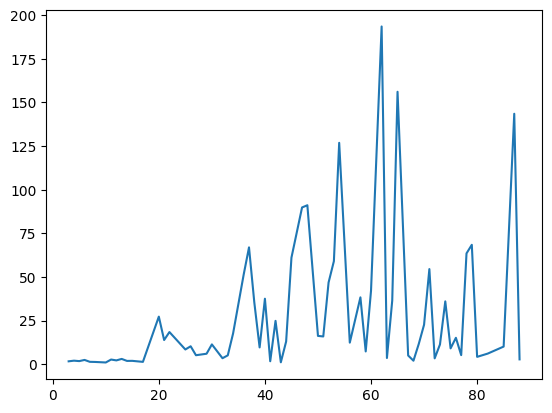

In [173]:
# 추출된 특성 시각화
plt.plot(extracted_x_train_mini['F_y__root_mean_square'])
plt.show()

### ML

Logistic Regression

1.0


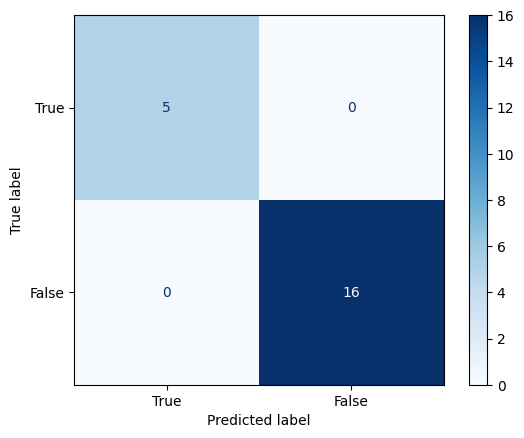

In [178]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# LogisticRegression 모델을 사용하여 분류
logistic = LogisticRegression()
logistic.fit(filtered_features_mini, y_train)

# score
print(logistic.score(filtered_features_mini_test, y_test))

classification_report(y_test, logistic.predict(filtered_features_mini_test), target_names=['true', 'false'], output_dict=True) 
# y_test 내부에 있는 true, false와 일치하는 이름을 표시합니다.

# confusion matrix
cm = confusion_matrix(y_test, logistic.predict(filtered_features_mini_test), labels=[True, False])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[True, False])
disp.plot(cmap=plt.cm.Blues)
plt.show()


RandomForest

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
1.0


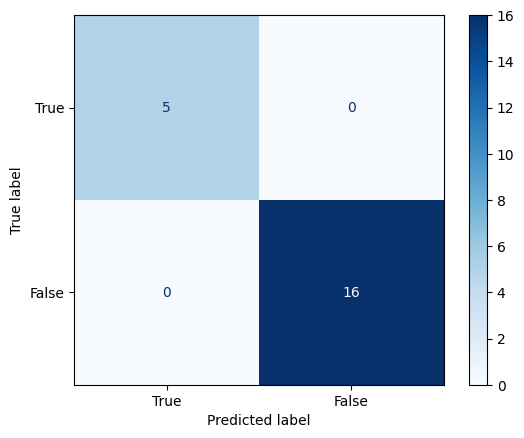

In [184]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

rf_clf = RandomForestClassifier(n_estimators = 10, max_depth = 3)

rf_clf.fit(filtered_features_mini, y_train)

print(rf_clf.get_params()) # 모델의 파라미터 확인
print(rf_clf.score(filtered_features_mini_test, y_test))

# score 
classification_report(y_test, rf_clf.predict(filtered_features_mini_test), target_names=['true', 'false'], output_dict=True)
# confusion matrix
cm = confusion_matrix(y_test, rf_clf.predict(filtered_features_mini_test), labels=[True, False])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[True, False])
disp.plot(cmap=plt.cm.Blues)
plt.show()

XGBoost

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 10, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
1.0


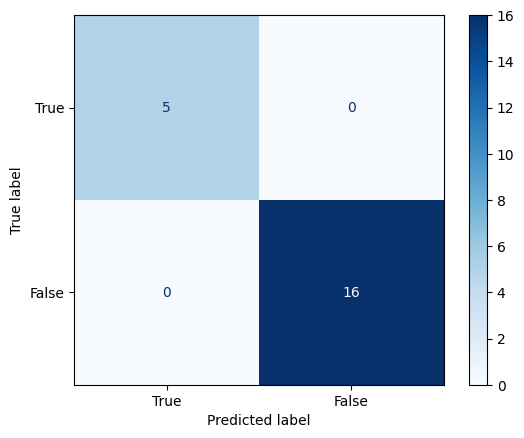

In [183]:
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

xgb_clf = xgb.XGBClassifier(n_estimators = 10, max_depth = 3)

# XGBoost 모델 학습
xgb_clf.fit(filtered_features_mini, y_train)

print(xgb_clf.get_params()) # 모델의 파라미터 확인

# score
print(xgb_clf.score(filtered_features_mini_test, y_test))
classification_report(y_test, xgb_clf.predict(filtered_features_mini_test), target_names=['true', 'false'], output_dict=True)
# confusion matrix
cm = confusion_matrix(y_test, xgb_clf.predict(filtered_features_mini_test), labels=[True, False])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[True, False])
disp.plot(cmap=plt.cm.Blues)
plt.show()